# Task 16: Forecasting — Time Series Trend & Prediction

**Objective:** Forecast Walmart weekly sales using time-series analysis.

**Steps:**
1. Data Preprocessing & Merging
2. Exploratory Data Analysis (EDA) - Trend, Seasonality, Decomposition, ACF/PACF
3. Modeling (Moving Average vs Exponential Smoothing)
4. Final Forecasting on Future Dates

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Set plot style
plt.style.use('ggplot')

## 1. Load and Preprocess Data

In [4]:
# Load datasets
train_path = 'train.csv'
test_path = 'test.csv'
features_path = 'features.csv'
stores_path = 'stores.csv'

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    features_df = pd.read_csv(features_path)
    stores_df = pd.read_csv(stores_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Files not found. Please ensure train.csv, test.csv, features.csv, and stores.csv are in the current directory.")

Data loaded successfully.


In [5]:
# Convert dates to datetime objects
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Aggregate sales by week (summing across stores and departments)
weekly_sales = train_df.groupby('Date')['Weekly_Sales'].sum().reset_index()
weekly_sales = weekly_sales.set_index('Date').sort_index()

# Resample ensures consistent frequency
weekly_sales = weekly_sales.resample('W-FRI').sum()

if weekly_sales.isnull().values.any():
    weekly_sales = weekly_sales.interpolate()

print("Train Data Shape:", weekly_sales.shape)
weekly_sales.head()

Train Data Shape: (143, 1)


,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30


## 2. Exploratory Data Analysis (EDA)

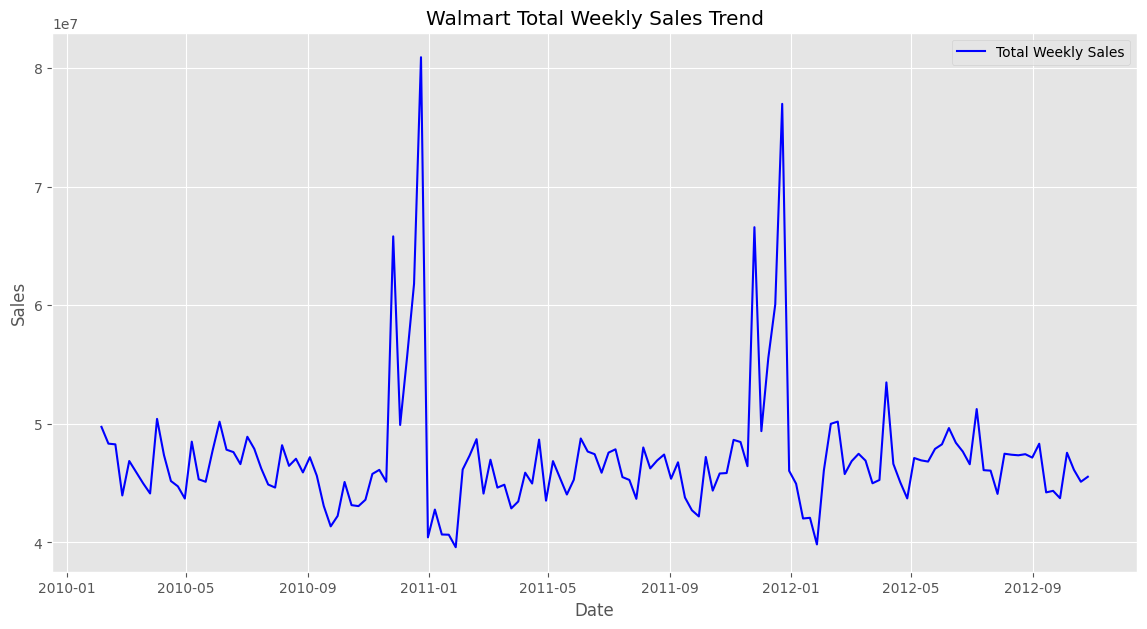

In [6]:
# 2.1 Sales Trend
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales, label='Total Weekly Sales', color='blue')
plt.title('Walmart Total Weekly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

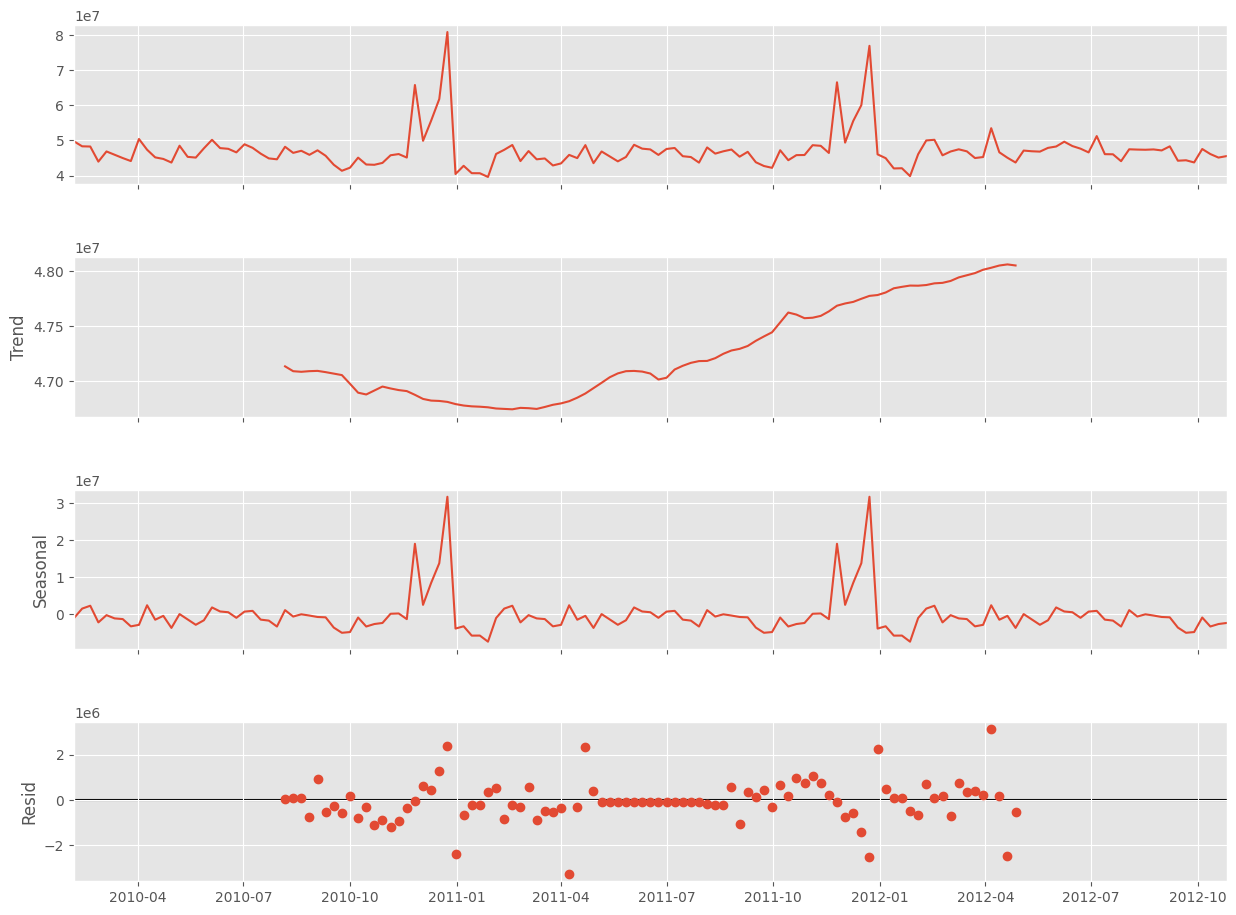

In [7]:
# 2.2 Seasonal Decomposition
# Decompose the series into Trend, Seasonal, and Residual components
decomposition = seasonal_decompose(weekly_sales, model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

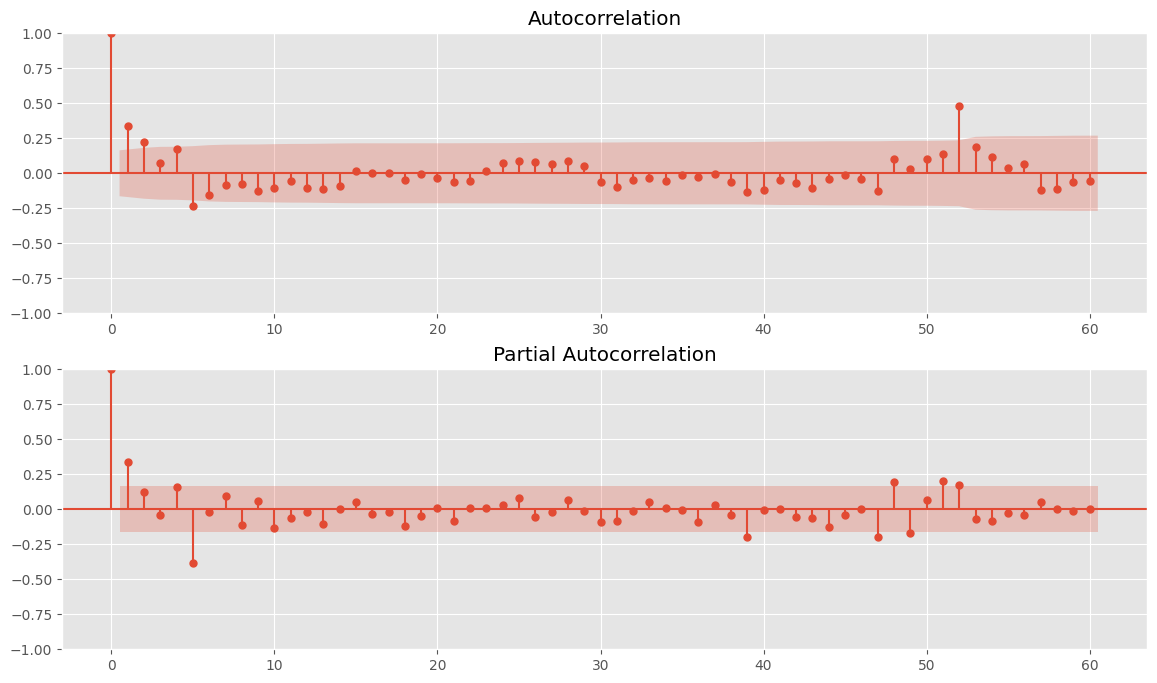

In [8]:
# 2.3 Autocorrelation Analysis (ACF/PACF)
# Helps determine seasonality and AR terms
fig, ax = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(weekly_sales, lags=60, ax=ax[0])
plot_pacf(weekly_sales, lags=60, ax=ax[1])
plt.show()

## 3. Modeling & Validation
We compare a simple **Moving Average** baseline against **Exponential Smoothing**.

In [9]:
# Split Train/Test for Validation (80/20 split)
split_idx = int(len(weekly_sales) * 0.8)
train_val = weekly_sales.iloc[:split_idx]
test_val = weekly_sales.iloc[split_idx:]

# Model 1: Moving Average (Baseline)
ma_forecast = test_val.copy()
last_4_avg = train_val['Weekly_Sales'].iloc[-4:].mean()
ma_forecast['Forecast'] = last_4_avg # Static Forecast

# Model 2: Exponential Smoothing (Holt-Winters)
es_model = ExponentialSmoothing(
    train_val['Weekly_Sales'],
    seasonal_periods=52,
    trend='add',
    seasonal='add',
    use_boxcox=False,
    initialization_method="estimated"
).fit()
es_forecast = es_model.forecast(len(test_val))

# Metrics Calculation
mae_ma = mean_absolute_error(test_val['Weekly_Sales'], ma_forecast['Forecast'])
mape_ma = mean_absolute_percentage_error(test_val['Weekly_Sales'], ma_forecast['Forecast'])

mae_es = mean_absolute_error(test_val['Weekly_Sales'], es_forecast)
mape_es = mean_absolute_percentage_error(test_val['Weekly_Sales'], es_forecast)

print(f"Validation MAE (Moving Avg): {mae_ma:,.2f}, MAPE: {mape_ma:.2%}")
print(f"Validation MAE (Exp Smoothing): {mae_es:,.2f}, MAPE: {mape_es:.2%}")

Validation MAE (Moving Avg): 1,511,343.84, MAPE: 3.30%
Validation MAE (Exp Smoothing): 1,825,176.69, MAPE: 3.94%


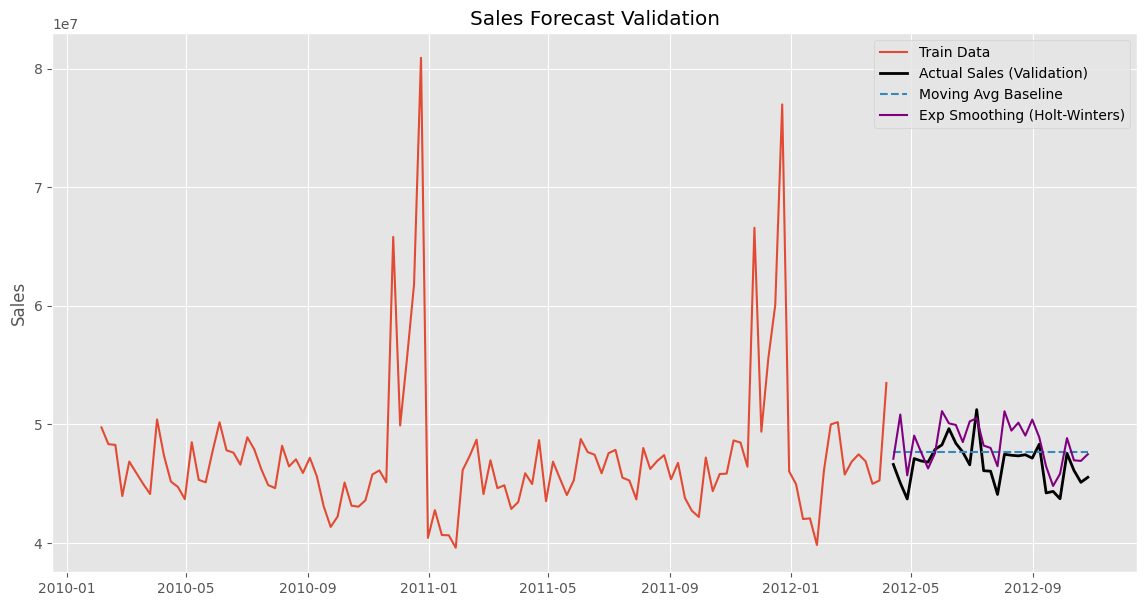

In [10]:
# Visualize Model Comparison
plt.figure(figsize=(14, 7))
plt.plot(train_val.index, train_val['Weekly_Sales'], label='Train Data')
plt.plot(test_val.index, test_val['Weekly_Sales'], label='Actual Sales (Validation)', color='black', linewidth=2)
plt.plot(test_val.index, ma_forecast['Forecast'], label='Moving Avg Baseline', linestyle='--')
plt.plot(test_val.index, es_forecast, label='Exp Smoothing (Holt-Winters)', linestyle='-', color='purple')
plt.title('Sales Forecast Validation')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 4. Final Forecasting (Future)
Retraining the best model (Exponential Smoothing) on the FULL dataset and predicting the horizon defined in `test.csv`.

Forecasting for 39 future weeks...


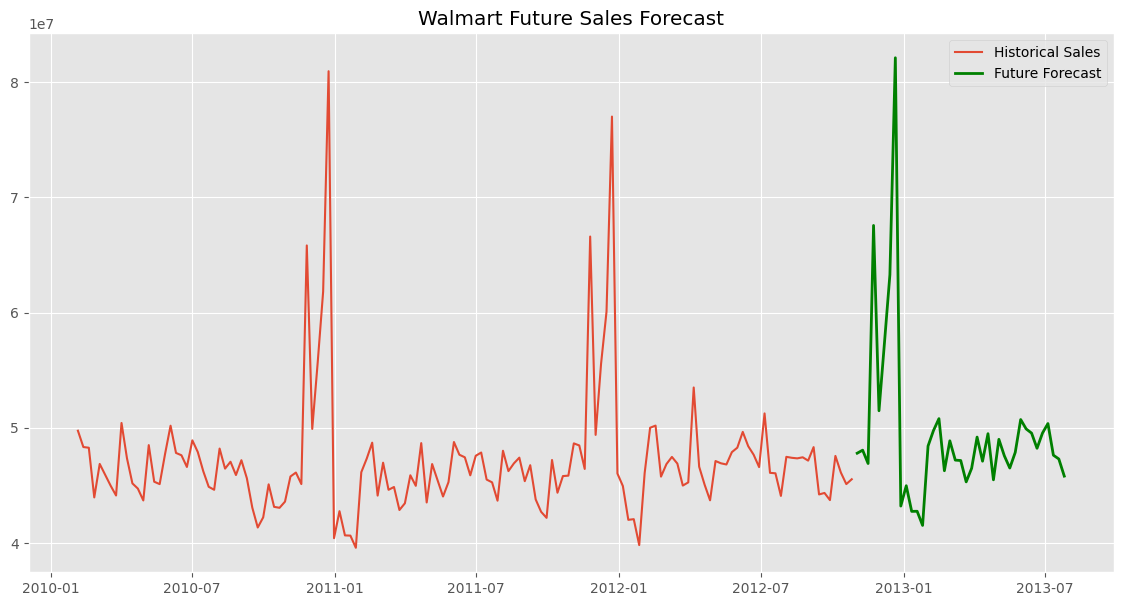

In [11]:
# Retrain on ALL Data
final_model = ExponentialSmoothing(
    weekly_sales['Weekly_Sales'],
    seasonal_periods=52,
    trend='add',
    seasonal='add',
    use_boxcox=False
).fit()

# Determine Forecast Horizon from test.csv dates
test_dates = test_df['Date'].unique()
test_dates = np.sort(pd.to_datetime(test_dates))
forecast_horizon_dates = pd.date_range(start=test_dates.min(), end=test_dates.max(), freq='W-FRI')

print(f"Forecasting for {len(forecast_horizon_dates)} future weeks...")

# Generate Forecast
future_forecast_values = final_model.forecast(len(forecast_horizon_dates))
final_forecast_df = pd.DataFrame({
    'Date': forecast_horizon_dates,
    'Forecast_Weekly_Sales': future_forecast_values
})
final_forecast_df.set_index('Date', inplace=True)

# Plot Final Forecast
plt.figure(figsize=(14, 7))
plt.plot(weekly_sales.index, weekly_sales['Weekly_Sales'], label='Historical Sales')
plt.plot(final_forecast_df.index, final_forecast_df['Forecast_Weekly_Sales'], label='Future Forecast', color='green', linewidth=2)
plt.title('Walmart Future Sales Forecast')
plt.legend()
plt.show()

In [12]:
# Export Results
output_df = test_val.copy()
output_df = output_df.rename(columns={'Weekly_Sales': 'Actual'})
output_df['Forecast'] = es_forecast.values
output_df['Error'] = output_df['Actual'] - output_df['Forecast']
output_df.to_csv('forecast_output.csv')

final_forecast_df.to_csv('future_forecast.csv')
print("Validation results saved to 'forecast_output.csv'")
print("Future forecast saved to 'future_forecast.csv'")

Validation results saved to 'forecast_output.csv'
Future forecast saved to 'future_forecast.csv'
